# Data storage handler

This data handler use [PyTables](https://www.pytables.org/) that is built on top of the HDF5 library, using the Python language and the NumPy package. It features an object-oriented interface that, combined with C extensions for the performance-critical parts of the code (generated using Cython), makes it a fast, yet extremely easy to use tool for interactively browse, process and search very large amounts of data. One important feature of [PyTables](https://www.pytables.org/) is that it optimizes memory and disk resources so that data takes much less space (specially if on-flight compression is used) than other solutions such as relational or object oriented databases.

In [3]:
import tables
import numpy as np
import json
from datetime import datetime

In [4]:
filename = 'sampple_eeg.h5'
CHANNELS = 16

In [5]:
from openbci_stream.utils import HDF5Writer, HDF5Reader

## Writer

In [6]:
writer = HDF5Writer('output.h5')

### Add header

In [7]:
header = {'sample_rate': 1000,
          'datetime': datetime.now().timestamp(),
         }
writer.add_header(header)

### Add EEG data

The number of channels is defined with first data addition:

In [8]:
eeg = np.random.normal(size=(16, 1000))  # channels x data
writer.add_eeg(eeg)

The number of channels can not be changed after define the first package:

In [9]:
eeg = np.random.normal(size=(8, 1000))
writer.add_eeg(eeg)

Is possible to add any amount of data:

In [10]:
eeg = np.random.normal(size=(16, 500))
writer.add_eeg(eeg)

A `timestamp` can be added to the data, in a separate command, in this case, `timestamp` _could_ be an array of the same length of data.

In [11]:
eeg = np.random.normal(size=(16, 2000))
timestamp = np.array([datetime.now().timestamp()]*2000)

writer.add_eeg(eeg)
writer.add_timestamp(timestamp)

Is possible to use the `timestamp` in a single command.

In [12]:
eeg = np.random.normal(size=(16, 2000))
timestamp = [datetime.now().timestamp()] * 2000

writer.add_eeg(eeg, timestamp)

### Extrapolated timestamps

Usually, we never have the `datetimes` for each value in a package, instead,  we have a single marker time for each package. This module was designed keeping mind these cases, so, is possible to set a single `timestamp` and `HDF5Reader` will interpolate the missing `timestamps`

In [13]:
eeg = np.random.normal(size=(16, 2000))
timestamp = datetime.now().timestamp()

writer.add_eeg(eeg, timestamp)

### Add markers

The `markers` can be added individually with their respective `timestamp`:

In [14]:
timestamp = datetime.now().timestamp()
marker = 'LEFT'
writer.add_marker(marker, timestamp)

Or in a dictionary structure with the marker as `key` and events as a list of `timestamps`:

In [15]:
markers = {
    'LEFT': [1603150888.752062, 1603150890.752062, 1603150892.752062],
    'RIGHT': [1603150889.752062, 1603150891.752062, 1603150893.752062],
} 

writer.add_markers(markers)

### Add annotations



The annotations are defined like in EDF format, with an `onset` and `duration` in seconds, and their corresponding `description`:

In [16]:
writer.add_annotation(onset=5, duration=1, description='This is an annotation, in EDF style')
writer.add_annotation(onset=45, duration=15, description='Electrode verification')
writer.add_annotation(onset=50, duration=3, description='Patient blinking')

Do no forget to close the file

In [17]:
writer.close()

## Reader

In [27]:
reader = HDF5Reader('output.h5')
reader

output.h5
2021-04-10 20:17:21.274841
MARKERS: ['LEFT', 'RIGHT']
SAMPLE_RATE: 1000
DATETIME: 1618103841.274841
SHAPE: [16, 7500]

In [20]:
reader.eeg

array([[ 0.25868927, -0.66543329,  0.03229383, ...,  0.78450966,
         0.574569  , -0.09854255],
       [ 0.26966891, -0.09300477, -0.80611687, ..., -0.06674499,
        -0.75905066,  0.69443338],
       [-0.61651975, -0.98729215, -0.46595438, ..., -0.88060761,
        -0.09198823, -0.81368015],
       ...,
       [ 0.15696397, -0.05382042, -0.47447657, ..., -0.93922117,
        -1.97117586, -1.97233181],
       [-0.12692569,  0.17508998,  0.73853735, ...,  0.44395487,
         0.88664937,  0.16267987],
       [-0.86684959, -0.07770241,  0.30604455, ...,  2.16666748,
         1.46009641,  1.20614713]])

In [21]:
reader.markers

{'LEFT': [1618103847.123672,
  1603150888.752062,
  1603150890.752062,
  1603150892.752062],
 'RIGHT': [1603150889.752062, 1603150891.752062, 1603150893.752062]}

In [22]:
reader.f.root.eeg_data

/eeg_data (EArray(16, 7500)) 'EEG time series'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 1
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (16, 512)

In [23]:
reader.f.root.timestamp

/timestamp (EArray(6000,)) 'EEG timestamp'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

In [24]:
reader.timestamp

array([1.61810385e+09, 1.61810385e+09, 1.61810385e+09, ...,
       1.61810385e+09, 1.61810385e+09, 1.61810385e+09])

In [25]:
reader.annotations

[[-1618103840.36316, 1, 'This is an annotation, in EDF style'],
 [-1618103800.36316, 15, 'Electrode verification'],
 [-1618103795.36316, 3, 'Patient blinking']]

In [28]:
reader.close()

## Examples using the `with` control-flow structure

This data format handlers can be used with the `with` structure:

### Writer

This example create a file with random data:

In [29]:
from openbci_stream.utils import HDF5Writer
from datetime import datetime, timedelta
import numpy as np
import os

now = datetime.now()

header = {'sample_rate': 1000,
          'datetime': now.timestamp(),
          'montage': 'standard_1020',
          'channels': {i:ch for i, ch in enumerate('Fp1,Fp2,F7,Fz,F8,C3,Cz,C4,T5,P3,Pz,P4,T6,O1,Oz,O2'.split(','))},
         }

filename = 'sample-eeg.h5'
if os.path.exists(filename):
    os.remove(filename)

with HDF5Writer(filename) as writer:

    writer.add_header(header)
    
    for i in range(60*5):
        eeg = np.random.normal(size=(16, 1000))
        aux = np.random.normal(size=(3, 1000))
        timestamp = (now + timedelta(seconds=i+1)).timestamp()
        writer.add_eeg(eeg, timestamp)
        writer.add_aux(aux)
    
#     events = np.linspace(1, 59*30, 15*30).astype(int)*1000
#     np.random.shuffle(events)
    markers = {}
    for i in range(5, 60*5//4, 4):
        markers.setdefault('RIGHT', []).append((now + timedelta(seconds=i+1)).timestamp())
        markers.setdefault('LEFT', []).append((now + timedelta(seconds=i+2)).timestamp())
        markers.setdefault('UP', []).append((now + timedelta(seconds=i+3)).timestamp())
        markers.setdefault('DOWN', []).append((now + timedelta(seconds=i+4)).timestamp())
    writer.add_markers(markers)
    
    
    writer.add_annotation((now + timedelta(seconds=10)).timestamp(), 1, 'Start run')
    writer.add_annotation((now + timedelta(seconds=60)).timestamp(), 1, 'Head moved')
    writer.add_annotation((now + timedelta(seconds=190)).timestamp(), 1, 'Blink')
    

### Reader

<ipython-input-4-ab8bda269688>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(channels)


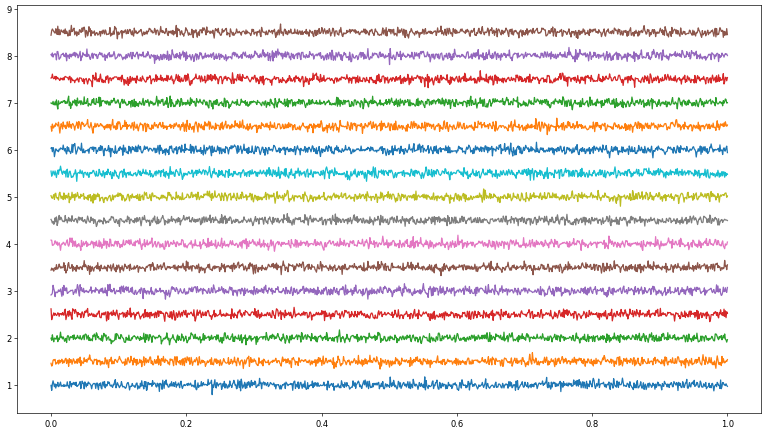

In [4]:
from openbci_stream.utils import HDF5Reader
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 9), dpi=60)

ax = plt.subplot(111)
filename = 'sample-eeg.h5'
with HDF5Reader(filename) as reader:
    
    channels = reader.header['channels']
    sample_rate = reader.header['sample_rate']

    t = np.linspace(0, 1, sample_rate)
    for i, ch in enumerate(reader.eeg[:, :sample_rate]):
        plt.plot(t, (ch-ch.mean())*0.1+i)
    ax.set_yticklabels(channels)

## MNE objects

`reader.get_epochs()` return an [mne.EpochsArray](https://mne.tools/stable/generated/mne.EpochsArray.html) object:

In [31]:
reader = HDF5Reader('sample-eeg.h5')

epochs = reader.get_epochs(tmin=-2, duration=6, markers=['RIGHT', 'LEFT'])

[mne.EpochsArray](https://mne.tools/stable/generated/mne.EpochsArray.html) needs an array of shape `(epochs, channels, time)`, we have channels and time, we only need to separate the epochs, here, an epoch is a trial, we will select trial by slicing around a `marker`. The argument `duration` in seconds set the _width_ for the trials, and `tmin` set _how much_ of signal before the marker will I analyze, finally, the argument `markers` set the labels to use, if empty, then will use all of them.

This feature needs at least `montage`, `channels`, and `sample_rate` configured in the header.

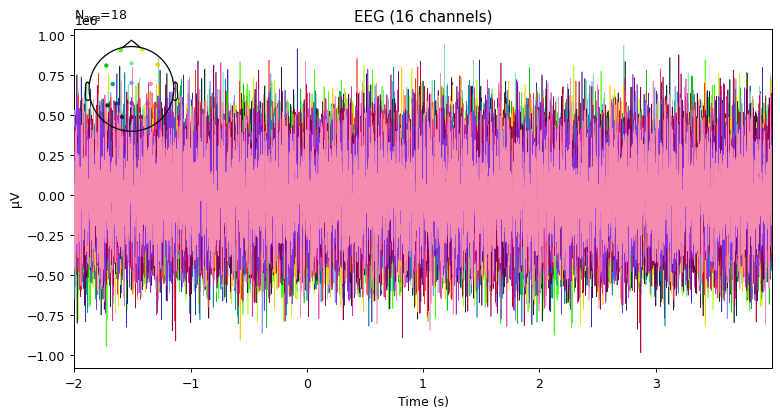

In [32]:
evoked = epochs['RIGHT'].average()

fig = plt.figure(figsize=(10, 5), dpi=90)
ax = plt.subplot(111)
evoked.plot(axes=ax, spatial_colors=True);

_This is only random data._

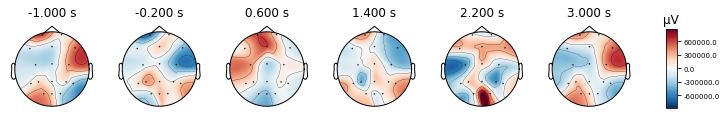

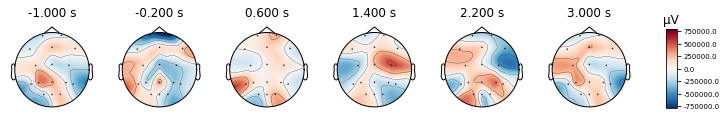

In [33]:
times = np.linspace(-1, 3, 6)

epochs['LEFT'].average().plot_topomap(times,)
epochs['RIGHT'].average().plot_topomap(times,);

In [16]:
reader.close()

## Offset correction

The offset correction is performed through the `start-offset` and `end-offset` headers (created automatically), it corresponds to the respective offset at beginning and end on a real-time acquisition, this feature is enabled by default and can be changed with the argument `offset_correction` in the `HDF5Reader` class.

In [ ]:
HDF5Reader('sample-eeg.h5', offset_correction=False)

## RAW `ndarray` objects
`get_data()` return a standard array `(epochs, channels, time)` and their respective (`classes`), receives the same arguments that `get_epochs`:

In [39]:
with HDF5Reader('sample-eeg.h5') as file:
    data, classes = file.get_data(tmin=-2, duration=6, markers=['RIGHT', 'LEFT'])

data.shape, classes.shape

((36, 16, 6000), (36,))

## Export to EDF

The European Data Format (EDF) is a standard file format designed for exchange and storage of medical time series, is possible to export to this format with the `to_edf` method. This file format needs special keys in the `header`:

  * **admincode:** str with the admincode.
  * **birthdate:** date object with the the birthdate of the patient.
  * **equipment:** str thats describes the measurement equpipment.
  * **gender:** int with the the gender, 1 is male, 0 is female.
  * **patientcode:** str with the patient code.
  * **patientname:** str with the patient name.
  * **patient_additional:** str with the additional patient information.
  * **recording_additional:** str wit the additional recording information.
  * **technician:** str with the technicians name.

In [36]:
reader = HDF5Reader('sample-eeg.h5')
reader.to_edf('sample-eeg.edf')
reader.close()

## Relative time markers

In the previous examples, we are using the markers with a `timestamp`, this is an **absolute** reference, is an exact point in time, the reason of that is because this feature was designed for real-time streaming, in this kind of implementations the main reference is the system clock, this approach makes easy to implement a markers register in an isolated system.

But, is possible to get relative time markers, based on the position in the data array using the attribute `reader.markers_relative`